<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ</a></span></li><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Построение-модели-без-разбиения-по-признаку-gender" data-toc-modified-id="Построение-модели-без-разбиения-по-признаку-gender-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Построение модели без разбиения по признаку gender</a></span></li><li><span><a href="#Построение-модели-c-учетом-разбиения-по-признаку-gender" data-toc-modified-id="Построение-модели-c-учетом-разбиения-по-признаку-gender-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Построение модели c учетом разбиения по признаку gender</a></span><ul class="toc-item"><li><span><a href="#Мужчины" data-toc-modified-id="Мужчины-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Мужчины</a></span></li><li><span><a href="#Женщины" data-toc-modified-id="Женщины-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Женщины</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

Попробую разобраться по каким признакам классифицируют пользователей на классы и и потренируюсь в мультиклассовой классификации. Данные взяты [отсюда](https://www.kaggle.com/code/kaushalkrishna2000/body-performance-dataset).

# Описание данных

Признаки:<br>
`age` - возраст <br>
`gender` - пол <br>
`height_cm` - рост, см <br>
`weight_kg` - вес, кг <br>
`body_fat_%` - содержание жира в организме, % <br>
`diastolic` - диастолическое давление <br>
`systolic` - систолическое давление <br>
`grip_force` - сила захвата, кг <br>
`sit_and_bend_forward_cm` - тест "сесть и дотянуться", см <br>
`sit_ups_counts` - число приседаний <br>
`broad_jump_cm` - прыжок в длину, см <br>

Целевой признак: <br>
`class` - класс - A, B, C, D

In [1]:
import pandas as pd   # импорт библиотек
import numpy as np 

import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

import phik

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_confusion_matrix

import shap

In [2]:
def shap_explaner (model, features):         # функция для построения shap summary_plot по каждому классу отдельно
    for i in range (0,4):
        print('Класс', i)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(features)
        shap.summary_plot(shap_values[i], features.values, feature_names = features.columns)

In [3]:
def feature_plot(feature):         # функция для построения графиков
    plt.figure(figsize=(15, 4))    # задаём размер графиков
    plt.subplot(1, 2, 1)           # положение графика
    df[feature].plot(kind = 'hist', bins=50)     # гистограмма
    
    plt.subplot(1,2,2)             # положение графика
    plt.boxplot(df[feature])       # диаграмма размаха
    plt.show()
# признаки по которым строятся графики    
columns = ['sit_and_bend_forward_cm', 'age', 'height_cm', 'body_fat_%', 'diastolic', 'systolic', 'grip_force',
           'sit_ups_counts', 'broad_jump_cm']

In [4]:
def true_false_pie(predictions, target): # график для построения круговой диаграммы истинных и ложных значений
    labels = 'False predictions', 'True predictions'
    sizes = [sum(predictions != target), sum(predictions == target)]
    explode = (0.2, 0)
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
    shadow=True, startangle=90, colors=['#A2D9CE', '#AF7AC5']);

# Исследовательский анализ

In [5]:
df = pd.read_csv('C:\\Users\\User\\Downloads\\Body_performance_Data.zip')

In [6]:
df.head()

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
0  27.0      M      172.3      75.24        21.3       80.0     130.0   
1  25.0      M      165.0      55.80        15.7       77.0     126.0   
2  31.0      M      179.6      78.00        20.1       92.0     152.0   
3  32.0      M      174.5      71.10        18.4       76.0     147.0   
4  28.0      M      173.8      67.70        17.1       70.0     127.0   

   gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  
0       54.9                     18.4            60.0          217.0     C  
1       36.4                     16.3            53.0          229.0     A  
2       44.8                     12.0            49.0          181.0     C  
3       41.4                     15.2            53.0          219.0     B  
4       43.5                     27.1            45.0          217.0     B

Данные загружены. Для удобства переименую названия столбцов, чтобы в дальнейшем было удобно работать.

In [7]:
# переименование столбцов
df = df.rename(columns={'gripForce':'grip_force', 'sit and bend forward_cm':'sit_and_bend_forward_cm',
                        'sit-ups counts':'sit_ups_counts', 'body fat_%':'body_fat_%', 'broad jump_cm':'broad_jump_cm'})

In [8]:
df.head(2)

age gender  height_cm  weight_kg  body_fat_%  diastolic  systolic  \
0  27.0      M      172.3      75.24        21.3       80.0     130.0   
1  25.0      M      165.0      55.80        15.7       77.0     126.0   

   grip_force  sit_and_bend_forward_cm  sit_ups_counts  broad_jump_cm class  
0        54.9                     18.4            60.0          217.0     C  
1        36.4                     16.3            53.0          229.0     A

В данных есть один дубликат. Удаляем эту строку.

In [9]:
df.duplicated().sum() # проверка на дубликаты

1

In [10]:
df = df.drop_duplicates() # удаление дубликата

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13392 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13392 non-null  float64
 1   gender                   13392 non-null  object 
 2   height_cm                13392 non-null  float64
 3   weight_kg                13392 non-null  float64
 4   body_fat_%               13392 non-null  float64
 5   diastolic                13392 non-null  float64
 6   systolic                 13392 non-null  float64
 7   grip_force               13392 non-null  float64
 8   sit_and_bend_forward_cm  13392 non-null  float64
 9   sit_ups_counts           13392 non-null  float64
 10  broad_jump_cm            13392 non-null  float64
 11  class                    13392 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.3+ MB


В датасэте 13392 строки. У признаков gender и class тип данных object, у остальных - float64.  Пропусков нет. Посмотрим есть ли аномалии. Для этого используем гистограммы и диаграммы размаха.

In [12]:
df.describe()

age     height_cm     weight_kg    body_fat_%     diastolic  \
count  13392.000000  13392.000000  13392.000000  13392.000000  13392.000000   
mean      36.775836    168.560671     67.448686     23.239608     78.797499   
std       13.625886      8.426305     11.949061      7.256829     10.742165   
min       21.000000    125.000000     26.300000      3.000000      0.000000   
25%       25.000000    162.400000     58.200000     18.000000     71.000000   
50%       32.000000    169.200000     67.400000     22.800000     79.000000   
75%       48.000000    174.800000     75.300000     28.000000     86.000000   
max       64.000000    193.800000    138.100000     78.400000    156.200000   

           systolic    grip_force  sit_and_bend_forward_cm  sit_ups_counts  \
count  13392.000000  13392.000000             13392.000000    13392.000000   
mean     130.238120     36.964569                15.208933       39.770385   
std       14.709536     10.624959                 8.456904       14.276902   
min        0.000000      0.000000               -25.000000        0.000000   
25%      120.000000     27.500000                10.900000       30.000000   
50%      130.000000     37.900000                16.200000       41.000000   
75%      141.000000     45.200000                20.700000       50.000000   
max      201.000000     70.500000               213.000000       80.000000   

       broad_jump_cm  
count   13392.000000  
mean      190.131355  
std        39.868988  
min         0.000000  
25%       162.000000  
50%       193.000000  
75%       221.000000  
max       303.000000

sit_and_bend_forward_cm


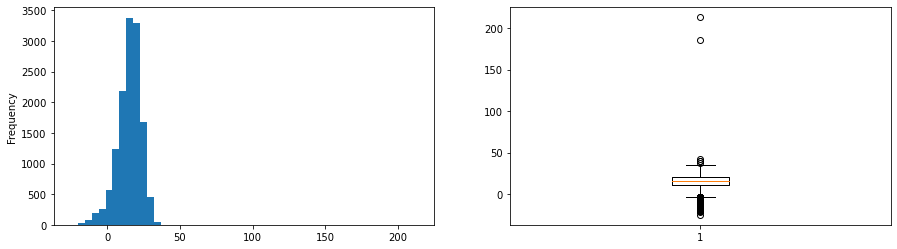

age


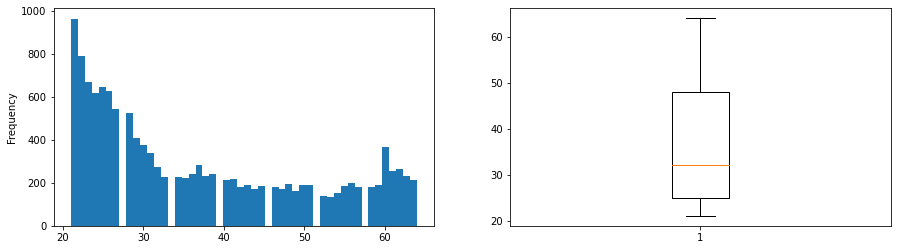

height_cm


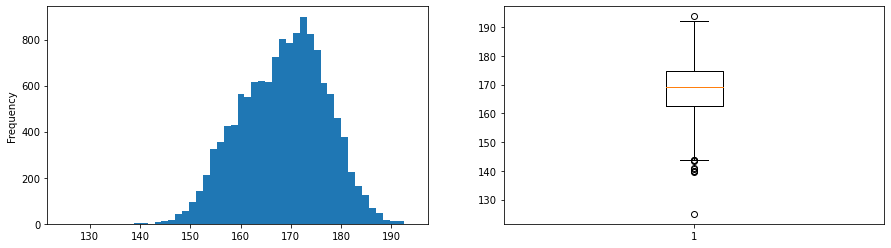

body_fat_%


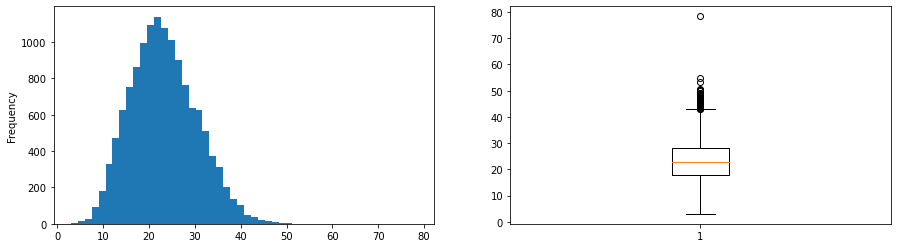

diastolic


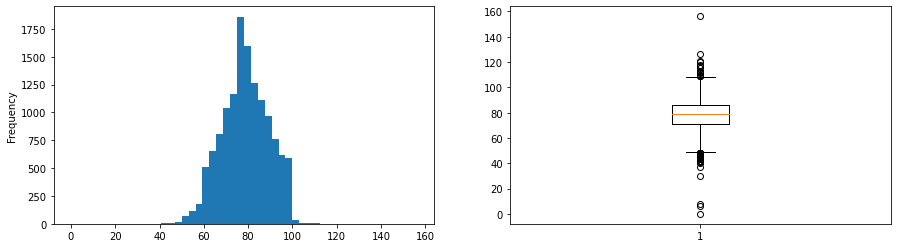

systolic


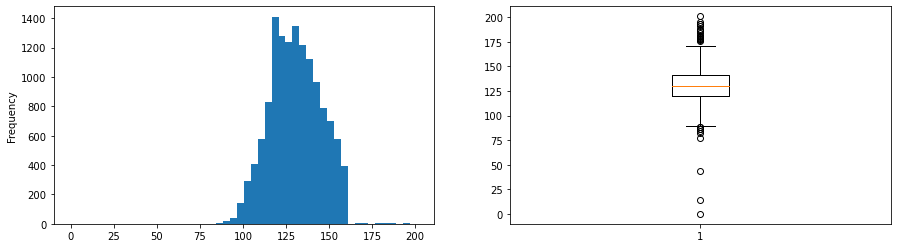

grip_force


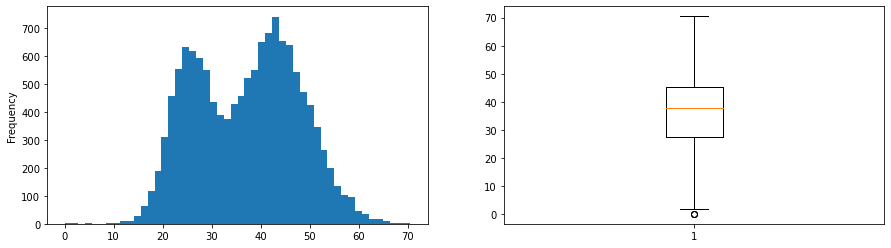

sit_ups_counts


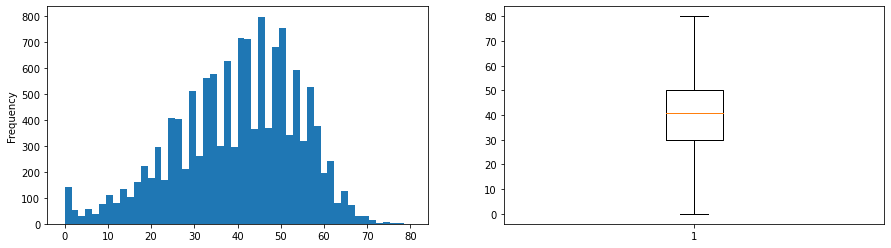

broad_jump_cm


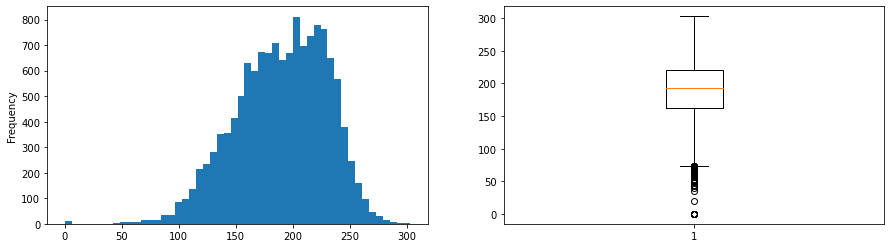

In [13]:
for column in columns:
    print(column)
    feature_plot(column)    

Из графиков можно увидеть аномальные значеня в колонке sit_and_bend_forward_cm. Результаты данного теста выглядят следующим образом:

|Adult Men     |	 Adult Women | Result      |
|--------------|-----------------|-------------|
|34cm or above | 37cm or above   |Excellent    |
|28 to 33cm	   | 33 to 36cm	     |Above average|
|23 to 27cm    | 29 to 32cm	     |Average      |
|16 to 22cm	   | 23 to 28cm      |Below average|
| Below 16cm   |Below 23cm       |Poor         |

[данные взяты с сайта verywellfit](https://www.verywellfit.com/sit-and-reach-flexibility-test-3120279)<br>

In [14]:
print(df[df['sit_and_bend_forward_cm'] <0]['class'].value_counts())
# сводная таблица по значениям в sit_and_bend_forward_cm с разбивкой по классам
display(pd.pivot_table(df, values='sit_and_bend_forward_cm',
                    columns=['class'], aggfunc=np.mean))
# сводная таблица по значениям в sit_and_bend_forward_cm больше 0 с разбивкой по классам
display(pd.pivot_table(df[df['sit_and_bend_forward_cm'] > 0], values='sit_and_bend_forward_cm',
                    columns=['class'], aggfunc=np.mean))

D    642
Name: class, dtype: int64


class                            A          B          C        D
sit_and_bend_forward_cm  21.392283  17.467586  14.390645  7.59026

class                            A          B          C          D
sit_and_bend_forward_cm  21.392283  17.467586  14.390645  10.941677

Имеем 642 значения sit_and_bend_forward_cm ниже 0 и все из класса D. Скорее всего имела место ошибка заполнения. При замене отрицательных чисел на положительные распределение между группами не изменится. Поэтому значения выше 50 см удалим. А в значениях ниже нуля уберём минус.

В колонке diastolic есть значения экстремально близкие к нулю. Значения ниже 30 предлагаю удалить.<br>
Так же в колонке systolic предлагаю удалить значения ниже 50.<br>
Остальные признаки вполне вписываются в реальные диапазоны. <br>
Минимальный возраст людей в исследовании составляет 21 год, максимальный - 64. Больше всего людей в возрасте от 21 до 30.<br>
Максимальное значение роста 193.8 см, минимальное 125 см. Нельзя исключать, что в выборке могут быть люди с карликовым ростом. Рост большинства людей от 160 см до 175 см.<br>
Процентное содержание жира в организме в нашем датасэте представлено в диапазоне от 3% до 78.4%. По найденым мной данным минимальное содержание жира в организме 3%.<br>
В распределении признака grip_force видим два пика от 20кг до 30кг, от 40кг до 50кг. Ниже на графике четко видно, что это разделение на мужчин и женщин.

In [15]:
fig = px.histogram(df, x="grip_force", color="gender", width=800, height=400)
fig.show()

Далее рассмотрим корреляцию признаков.

In [16]:
df.phik_matrix(interval_cols = ['age', 'height_cm', 'weight_kg', 'body_fat_%', 'diastolic', 'systolic',
                                'grip_force', 'sit_and_bend_forward_cm', 'sit_ups_counts', 'broad_jump_cm'])

age    gender  height_cm  weight_kg  body_fat_%  \
age                      1.000000  0.190229   0.262142   0.215453    0.206034   
gender                   0.190229  1.000000   0.743627   0.884874    0.717627   
height_cm                0.262142  0.743627   1.000000   0.587578    0.391684   
weight_kg                0.215453  0.884874   0.587578   1.000000    0.304920   
body_fat_%               0.206034  0.717627   0.391684   0.304920    1.000000   
diastolic                0.189392  0.281829   0.109927   0.246788    0.047891   
systolic                 0.168297  0.312040   0.245256   0.245319    0.070923   
grip_force               0.314956  0.976534   0.565934   0.689521    0.418333   
sit_and_bend_forward_cm  0.117225  0.243245   0.169164   0.305262    0.080347   
sit_ups_counts           0.541281  0.610244   0.399216   0.353513    0.494834   
broad_jump_cm            0.488950  0.893591   0.515151   0.531154    0.536800   
class                    0.119792  0.136410   0.097899   0.260651    0.466164   

                         diastolic  systolic  grip_force  \
age                       0.189392  0.168297    0.314956   
gender                    0.281829  0.312040    0.976534   
height_cm                 0.109927  0.245256    0.565934   
weight_kg                 0.246788  0.245319    0.689521   
body_fat_%                0.047891  0.070923    0.418333   
diastolic                 1.000000  0.601937    0.210860   
systolic                  0.601937  1.000000    0.221723   
grip_force                0.210860  0.221723    1.000000   
sit_and_bend_forward_cm   0.093569  0.078448    0.284042   
sit_ups_counts            0.053336  0.081682    0.573319   
broad_jump_cm             0.114079  0.150340    0.712932   
class                     0.076180  0.048491    0.231360   

                         sit_and_bend_forward_cm  sit_ups_counts  \
age                                     0.117225        0.541281   
gender                                  0.243245        0.610244   
height_cm                               0.169164        0.399216   
weight_kg                               0.305262        0.353513   
body_fat_%                              0.080347        0.494834   
diastolic                               0.093569        0.053336   
systolic                                0.078448        0.081682   
grip_force                              0.284042        0.573319   
sit_and_bend_forward_cm                 1.000000        0.164604   
sit_ups_counts                          0.164604        1.000000   
broad_jump_cm                           0.190850        0.747039   
class                                   0.332413        0.448386   

                         broad_jump_cm     class  
age                           0.488950  0.119792  
gender                        0.893591  0.136410  
height_cm                     0.515151  0.097899  
weight_kg                     0.531154  0.260651  
body_fat_%                    0.536800  0.466164  
diastolic                     0.114079  0.076180  
systolic                      0.150340  0.048491  
grip_force                    0.712932  0.231360  
sit_and_bend_forward_cm       0.190850  0.332413  
sit_ups_counts                0.747039  0.448386  
broad_jump_cm                 1.000000  0.294348  
class                         0.294348  1.000000

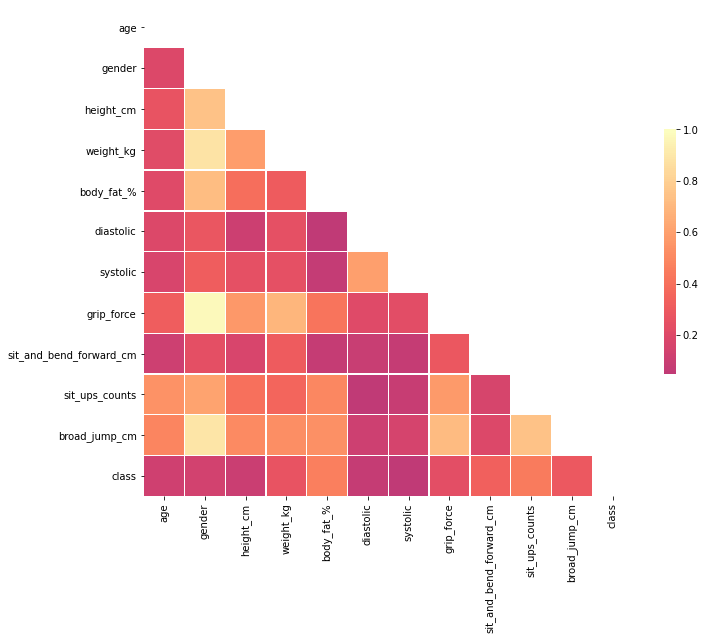

In [17]:
corr = df.phik_matrix(interval_cols = ['age', 'height_cm', 'weight_kg', 'body_fat_%', 'diastolic', 'systolic',
                                       'grip_force', 'sit_and_bend_forward_cm', 'sit_ups_counts', 'broad_jump_cm'])
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap='magma', vmax=1, center=0,
            square=True, linewidths=.3, cbar_kws={"shrink": .5});

Признаки body_fat_%, sit_ups_counts больше всего коррелируют с целевым признаком, но не достаточно сильно. Наблюдается сильная корреляция признака gender с показателями силы. Предполагаю, что для мужчин и женщин порог вхождения в класс расчитывается в зависимости от пола. Стоит попробовать сделать разные модели для мужчин и женщин.

In [18]:
df_male_female = df.copy() # подготовим данные для дальнейшего исследования в зависимости от пола

# Подготовка признаков

На основании анализа мы выделили следующие проблемы:
- значения меньше 0 в колонке sit_and_bend_forward_cm;
- значения больше 50 см в колонке sit_and_bend_forward_cm;
- экстремально низкие значения в колонке diastolic;
- экстремально низкие значения в колонке systolic.

In [19]:
df['sit_and_bend_forward_cm'] = abs(df['sit_and_bend_forward_cm']) # уберём минусовые значения
display(pd.pivot_table(df, values='sit_and_bend_forward_cm',
                    columns=['class'], aggfunc=np.mean))

class                            A          B          C          D
sit_and_bend_forward_cm  21.392283  17.467586  14.390645  10.019666

In [20]:
df = df[df['sit_and_bend_forward_cm'] < 150] # убираем два значения больше 50см

In [21]:
display(df[df['diastolic'] < 30]) 
df = df[df['diastolic'] > 30] # убираем значения diastolic меньше 30.

age gender  height_cm  weight_kg  body_fat_%  diastolic  systolic  \
336    35.0      M      173.1      77.60        22.8        8.0     122.0   
3524   44.0      M      177.0      78.28        22.1        6.0     145.0   
10624  26.0      F      160.0      63.56        32.0        0.0       0.0   

       grip_force  sit_and_bend_forward_cm  sit_ups_counts  broad_jump_cm  \
336          46.4                     16.7            47.0          216.0   
3524         47.4                     10.5            42.0          215.0   
10624        23.7                     17.1            23.0          128.0   

      class  
336       B  
3524      B  
10624     D

In [22]:
display(df[df['systolic'] < 50])
df = df[df['systolic'] > 50] # убираем значения systolic меньше 50.

age gender  height_cm  weight_kg  body_fat_%  diastolic  systolic  \
7597  30.0      M      166.6      66.08        14.4       67.0      14.0   
8217  31.0      M      176.7      80.32        20.8       46.2      43.9   

      grip_force  sit_and_bend_forward_cm  sit_ups_counts  broad_jump_cm class  
7597        53.8                     17.2            57.0          221.0     A  
8217        43.9                     17.2            57.0          221.0     B

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13384 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13384 non-null  float64
 1   gender                   13384 non-null  object 
 2   height_cm                13384 non-null  float64
 3   weight_kg                13384 non-null  float64
 4   body_fat_%               13384 non-null  float64
 5   diastolic                13384 non-null  float64
 6   systolic                 13384 non-null  float64
 7   grip_force               13384 non-null  float64
 8   sit_and_bend_forward_cm  13384 non-null  float64
 9   sit_ups_counts           13384 non-null  float64
 10  broad_jump_cm            13384 non-null  float64
 11  class                    13384 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.3+ MB


Итого удалили восемь строк из данных. 

In [24]:
fig = px.histogram(df, x="class")
fig.show()

Как видим дисбаланса классов нет. Каждый класс встречается в данных около 3340 раз.

In [25]:
df['class'].replace(['A','B','C','D'],[0,1,2,3],inplace=True) # заменяем категориальные признаки числами
df['gender'].replace(['F','M'],[0,1],inplace=True)

In [26]:
df.head()

age  gender  height_cm  weight_kg  body_fat_%  diastolic  systolic  \
0  27.0       1      172.3      75.24        21.3       80.0     130.0   
1  25.0       1      165.0      55.80        15.7       77.0     126.0   
2  31.0       1      179.6      78.00        20.1       92.0     152.0   
3  32.0       1      174.5      71.10        18.4       76.0     147.0   
4  28.0       1      173.8      67.70        17.1       70.0     127.0   

   grip_force  sit_and_bend_forward_cm  sit_ups_counts  broad_jump_cm  class  
0        54.9                     18.4            60.0          217.0      2  
1        36.4                     16.3            53.0          229.0      0  
2        44.8                     12.0            49.0          181.0      2  
3        41.4                     15.2            53.0          219.0      1  
4        43.5                     27.1            45.0          217.0      1

# Построение модели без разбиения по признаку gender

Для предсказания классов будем использовать CatBoostClassifier.

In [27]:
features = df.drop(columns='class') # обучающие признаки
target = df['class']                # целевой признак
# разбиение на обучающую и тренировочную выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2,
                                                                            random_state=1)

In [28]:
catboost2 = CatBoostClassifier(loss_function='MultiClass', random_seed=1, silent=True)

catboost_params = {                                      # параметры для подбора лучшей модели
 'depth': [x for x in range(1,6)],
 'iterations': [x for x in range(100,1100, 100)],
 'learning_rate': [0.1],
 'l2_leaf_reg':[x for x in range(1,5)] 
} 
grid_search_catboost2 = GridSearchCV(catboost2,
                                    catboost_params, 
                                    verbose=3,
                                    cv=5,
                                    n_jobs=-1,
                                    scoring='accuracy')

grid_search_catboost2.fit(features_train, target_train)
catboost_best_params = grid_search_catboost2.best_params_
accuracy_score_grid_search = grid_search_catboost2.best_score_

print('Лучшие параметры модели', catboost_best_params)
print('Лучший accuracy_score', accuracy_score_grid_search)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Лучшие параметры модели {'depth': 5, 'iterations': 600, 'l2_leaf_reg': 2, 'learning_rate': 0.1}
Лучший accuracy_score 0.7290545051899009


In [29]:
catboost = CatBoostClassifier(loss_function='MultiClass', random_seed=1, silent=True, depth=5, iterations=600, 
l2_leaf_reg=2, learning_rate=0.1)
catboost.fit(features_train, target_train)               # обучение
predictions_catboost = catboost.predict(features_test)   # предсказания
print(accuracy_score(target_test, predictions_catboost))

0.7217033993276055


Значение метрики accuracy для модели catboost составляет 0,72

In [30]:
# изменение формы predictions_catboost для использования в функции true_false_pie 
predictions_1d = np.reshape(predictions_catboost, len(predictions_catboost)) 

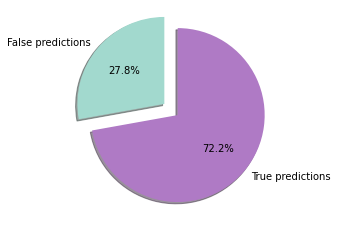

In [31]:
true_false_pie(predictions_1d, target_test)

Рассмотрим какие ошибки совершает наша модель. Для этого используем матрицу ошибок. Она имеет следующий вид.

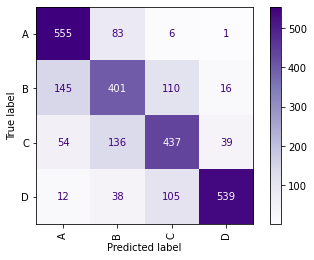

In [32]:
class_names = ['A', 'B', 'C', 'D']
disp = plot_confusion_matrix(catboost, features_test, target_test, display_labels=class_names,
                             cmap=plt.cm.Purples, xticks_rotation='vertical')

С помощью матрицы ошибок можем увидеть, что модель чаще путает соседние классы. Правильно предсказанных ответов большинство в каждом классе. 

С помощью библиотеки shap посмотрим какие признаки признаки более значимы при присвоении класса.


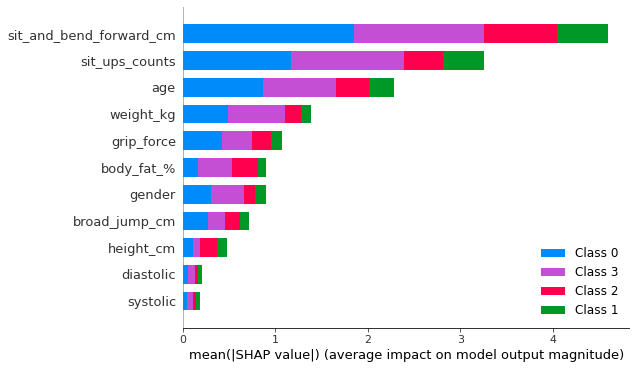

In [33]:
shap_values = shap.TreeExplainer(catboost).shap_values(features_test)
shap.summary_plot(shap_values, features_test)

Класс 0


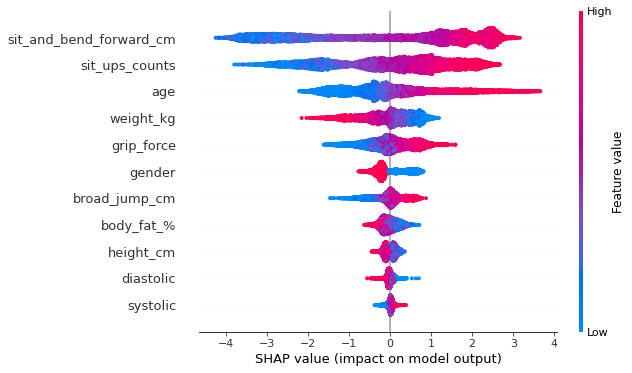

Класс 1


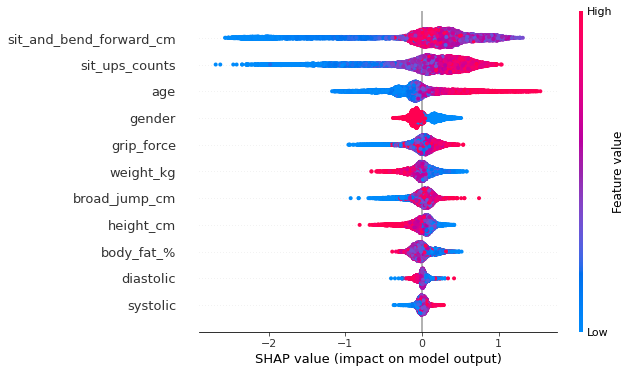

Класс 2


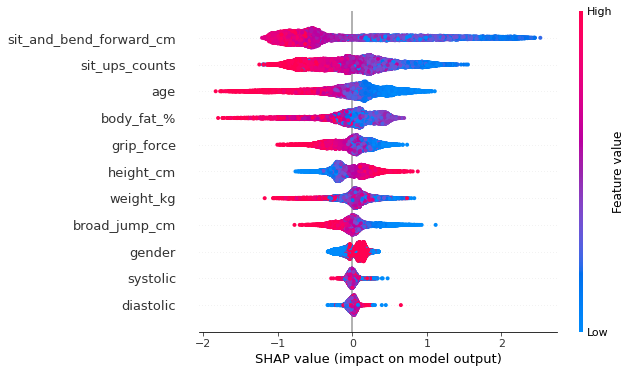

Класс 3


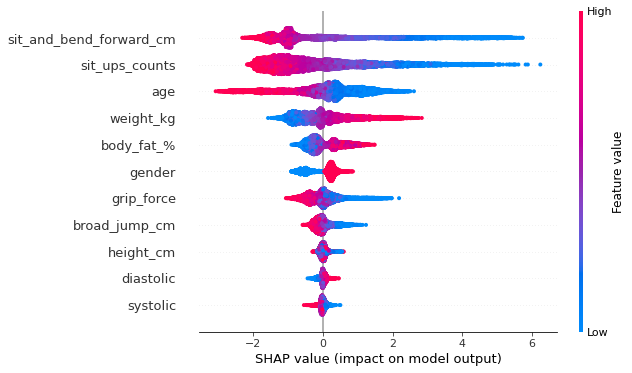

In [34]:
shap_explaner(catboost, features)

Признаки sit_and_bend_forward_cm, sit_ups_counts, age являются самыми значимыми для модели. <br>
Для присвоения к классам А и В характерно высокое значение sit_and_bend_forward_cm и sit_ups_counts, а также высокие значения возраста.<br>
Для присвоения к классам C и D характерны низкие значения sit_and_bend_forward_cm, sit_ups_counts и age. 

# Построение модели c учетом разбиения по признаку gender

In [35]:
fig = px.histogram(df_male_female, x="class", color='gender')
fig.show() 

Мужчин представлено больше, но распределение примерно одинаковое по классам.

In [36]:
df_male = df_male_female[df_male_female['gender'] == 'M'].copy()
df_male = df_male.drop(columns=['gender'])

In [37]:
df_female = df_male_female[df_male_female['gender'] == 'F'].copy()
df_female = df_female.drop(columns=['gender'])

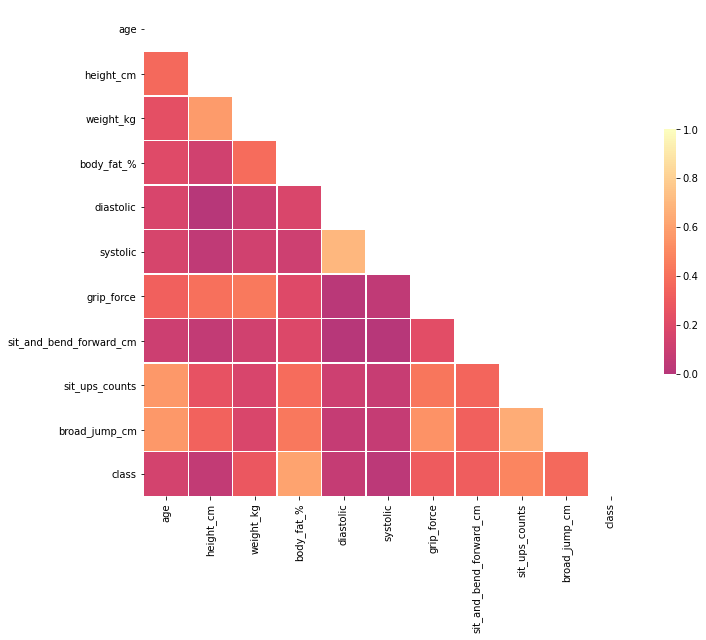

In [38]:
corr_male = df_male.phik_matrix(interval_cols = ['age', 'height_cm', 'weight_kg', 'body_fat_%', 'diastolic', 'systolic',
                                       'grip_force', 'sit_and_bend_forward_cm', 'sit_ups_counts', 'broad_jump_cm'])
mask = np.triu(np.ones_like(corr_male, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_male, mask=mask, cmap='magma', vmax=1, center=0,
            square=True, linewidths=.3, cbar_kws={"shrink": .5});

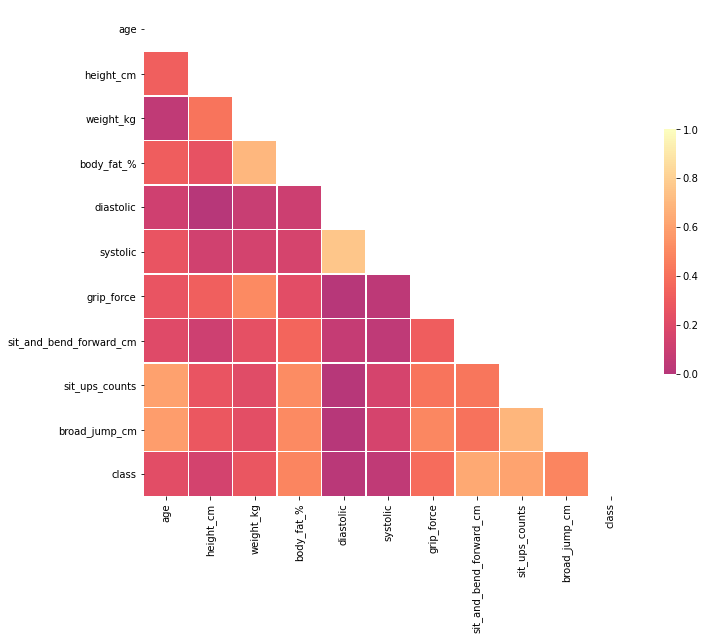

In [39]:
corr_female = df_female.phik_matrix(interval_cols = ['age', 'height_cm', 'weight_kg', 'body_fat_%', 'diastolic',
                                                     'systolic','grip_force', 'sit_and_bend_forward_cm',
                                                     'sit_ups_counts', 'broad_jump_cm'])
mask = np.triu(np.ones_like(corr_female, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_female, mask=mask, cmap='magma', vmax=1, center=0,
            square=True, linewidths=.3, cbar_kws={"shrink": .5});

Матрица корреляции при разбиении по признаку gender не изменяется.

## Мужчины

In [40]:
df_male['class'].replace(['A','B','C','D'],[0,1,2,3],inplace=True) # заменяем категориальные признаки числами

In [41]:
features_male = df_male.drop(columns='class') # обучающие признаки
target_male = df_male['class']                # целевой признак
# # разбиение на обучающую и тренировочную выборки
features_train_male, features_test_male, target_train_male, target_test_male = train_test_split(features_male, 
                                                                                                target_male,
                                                                                                test_size=0.2,
                                                                                                random_state=1)

In [42]:
catboost_male1 = CatBoostClassifier(loss_function='MultiClass', random_seed=290822, silent=True)

catboost_params_male = {
 'depth': [x for x in range(1,6)],
 'iterations': [x for x in range(100,1100, 100)],
 'learning_rate': [0.1],
 'l2_leaf_reg':[x for x in range(1,5)] 
} 

grid_search_catboost_male = GridSearchCV(catboost_male1,
                                    catboost_params_male, 
                                    verbose=3,
                                    cv=5,
                                    n_jobs=-1,
                                    scoring='accuracy')

grid_search_catboost_male.fit(features_train_male, target_train_male)
catboost_best_params_male = grid_search_catboost_male.best_params_
accuracy_score_male = grid_search_catboost_male.best_score_

print('Лучшие параметры модели', catboost_best_params_male)
print('Лучший accuracy_score', accuracy_score_male)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Лучшие параметры модели {'depth': 5, 'iterations': 400, 'l2_leaf_reg': 4, 'learning_rate': 0.1}
Лучший accuracy_score 0.7419171840167441


In [43]:
catboost_male = CatBoostClassifier(loss_function='MultiClass', random_seed=290822, silent=True, depth=5, iterations=400,
       l2_leaf_reg=4, learning_rate=0.1)
catboost_male.fit(features_train_male, target_train_male)              # обучение
predictions_catboost_male = catboost_male.predict(features_test_male)  # предсказания
print(accuracy_score(target_test_male, predictions_catboost_male))

0.7550177095631642


In [44]:
# изменение формы predictions_catboost для использования в функции true_false_pie 
predictions_1d_male = np.reshape(predictions_catboost_male, len(predictions_catboost_male))

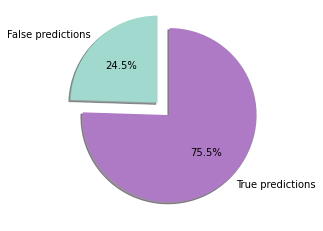

In [45]:
true_false_pie(predictions_1d_male, target_test_male)

Значение accuracy для catboost_male составляет 0,75.

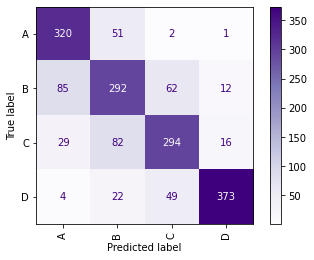

In [46]:
class_names = ['A', 'B', 'C', 'D']
disp = plot_confusion_matrix(catboost_male, features_test_male, target_test_male, display_labels=class_names,
                             cmap=plt.cm.Purples, xticks_rotation='vertical')

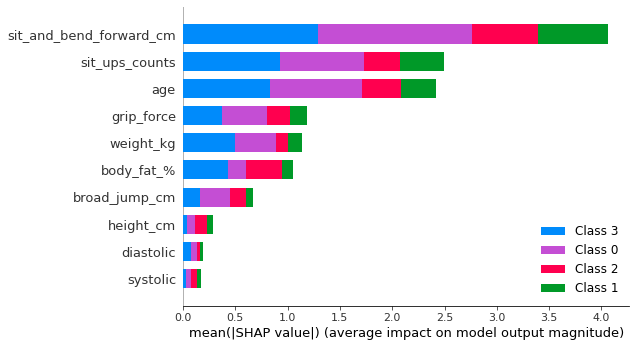

In [47]:
shap_values_male = shap.TreeExplainer(catboost_male).shap_values(features_test_male)
shap.summary_plot(shap_values_male, features_test_male)

Класс 0


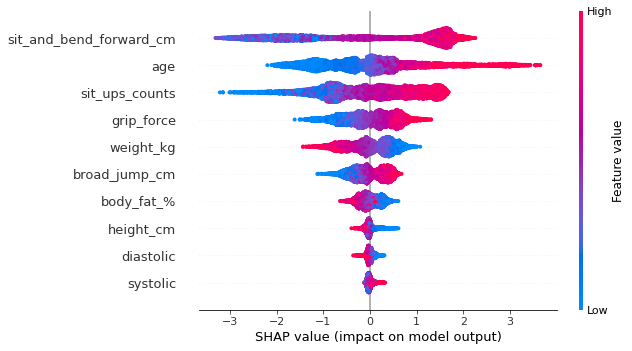

Класс 1


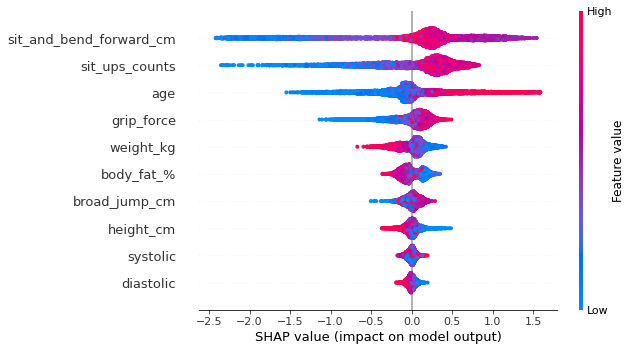

Класс 2


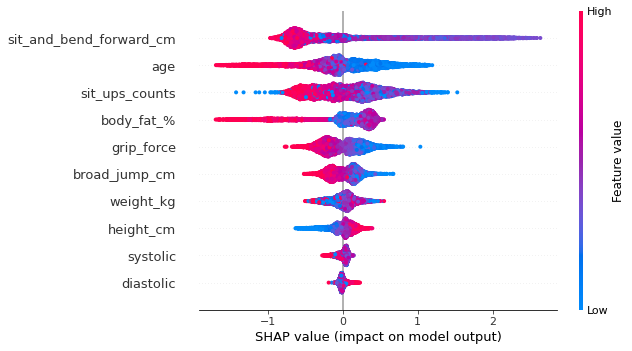

Класс 3


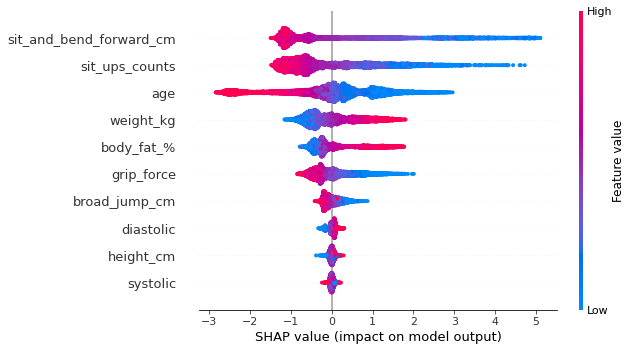

In [48]:
shap_explaner(catboost_male, features_male)

Для присвоения к классам A и B характерны более высокие значения sit_and_bend_forward_cm и sit_ups_counts и age. Для C и D, наоборот, низкие. Но в точности принадлежность к классу определяют только экстремально низкие или высокие значения. Средние значения этих показателей могут относиться к любому классу.

## Женщины

In [49]:
df_female['class'].replace(['A','B','C','D'],[0,1,2,3],inplace=True) # заменяем категориальные признаки числами

In [50]:
features_female = df_female.drop(columns='class')  # обучающие признаки
target_female = df_female['class']                 # целевой признак
# разбиение на обучающую и тренировочную выборки
features_train_female,features_test_female,target_train_female,target_test_female = train_test_split(features_female,
                                                        target_female, test_size=0.2, random_state=1)

In [51]:
catboost_female1 = CatBoostClassifier(loss_function='MultiClass', random_seed=1, silent=True)

catboost_params_female = {
 'depth': [x for x in range(1,6)],
 'iterations': [x for x in range(100,1100, 100)],
 'learning_rate': [0.1],
 'l2_leaf_reg':[x for x in range(1,5)] 
} 

grid_search_catboost_female = GridSearchCV(catboost_female1,
                                    catboost_params_female, 
                                    verbose=3,
                                    cv=5,
                                    n_jobs=-1,
                                    scoring='accuracy')

grid_search_catboost_female.fit(features_train_female, target_train_female)
catboost_best_params_female = grid_search_catboost_female.best_params_
accuracy_score_female = grid_search_catboost_female.best_score_

print('Лучшие параметры модели', catboost_best_params_female)
print('Лучший accuracy_score', accuracy_score_female)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Лучшие параметры модели {'depth': 4, 'iterations': 400, 'l2_leaf_reg': 2, 'learning_rate': 0.1}
Лучший accuracy_score 0.7439086294416244


In [52]:
catboost_female = CatBoostClassifier(loss_function='MultiClass', random_seed=290822, silent=True, depth=4, iterations=400,
       l2_leaf_reg=2, learning_rate=0.1)
catboost_female.fit(features_train_female, target_train_female)              # обучение
predictions_catboost_female = catboost_female.predict(features_test_female)  # предсказания
print(accuracy_score(target_test_female, predictions_catboost_female))

0.7522842639593909


In [53]:
# изменение формы predictions_catboost для использования в функции true_false_pie 
predictions_1d_female = np.reshape(predictions_catboost_female, len(predictions_catboost_female))

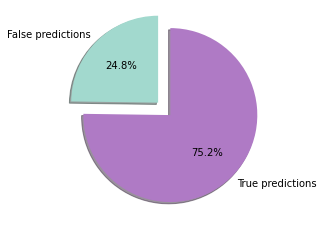

In [54]:
true_false_pie(predictions_1d_female, target_test_female)

Значение accuracy для catboost_female сосставляет 0,75.

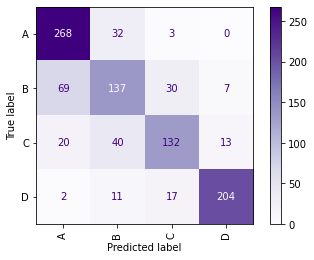

In [55]:
class_names = ['A', 'B', 'C', 'D']
disp = plot_confusion_matrix(catboost_female, features_test_female, target_test_female, display_labels=class_names,
                             cmap=plt.cm.Purples, xticks_rotation='vertical')

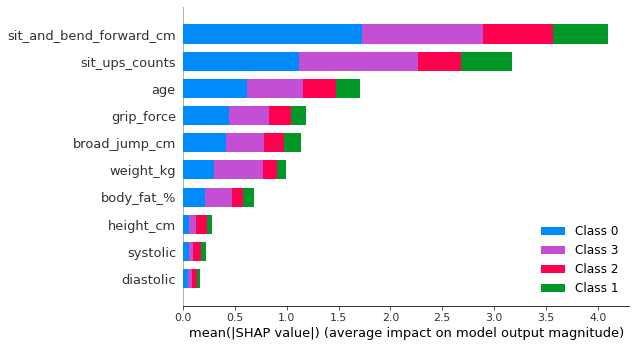

In [56]:
shap_values_female = shap.TreeExplainer(catboost_female).shap_values(features_test_female)
shap.summary_plot(shap_values_female, features_test_female)

Класс 0


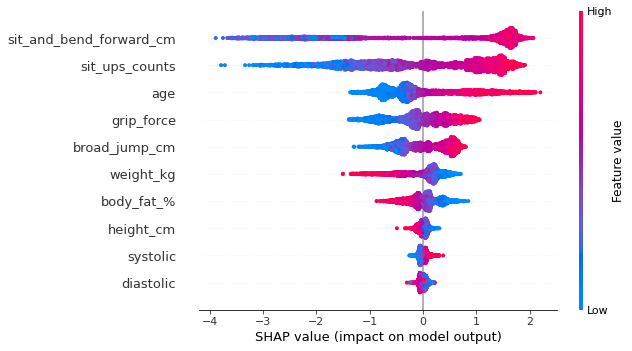

Класс 1


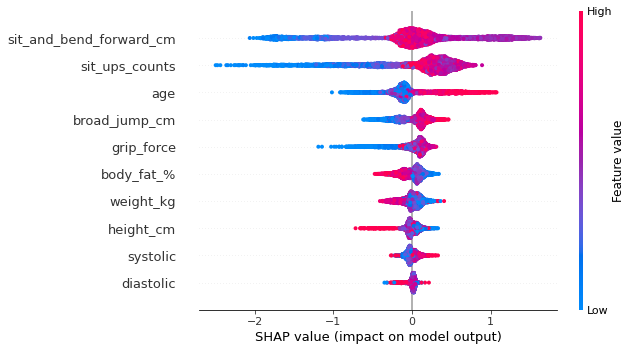

Класс 2


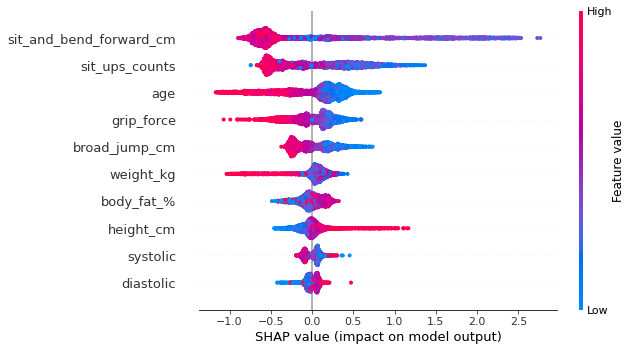

Класс 3


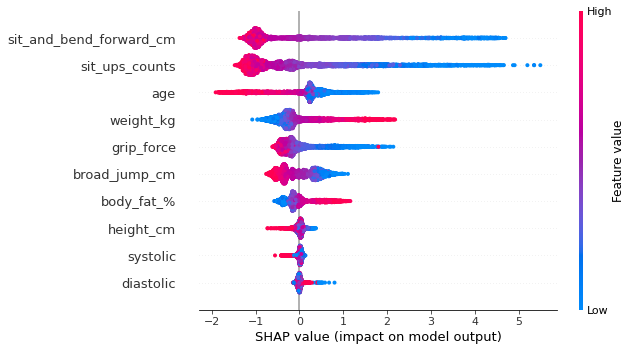

In [57]:
shap_explaner(catboost_female, features_female)

Как мы можем видеть из графиков выше. Для классов A и B характерны более высокие значения sit_and_bend_forward_cm и sit_ups_counts и age. Для C и D, наоборот, низкие. Но в точности принадлежность к классу определяют только экстремально низкие или высокие значения. Средние значения этих показателей могут относиться к любому классу.

In [58]:
confusion_matrix_whole = confusion_matrix(target_test, predictions_catboost, labels=[0,1,2,3])
confusion_matrix_female = confusion_matrix(target_test_female, predictions_catboost_female)
confusion_matrix_male = confusion_matrix(target_test_male, predictions_catboost_male)
confusion_matrix_male_and_female = confusion_matrix_male + confusion_matrix_female
print('Матрица с разбивкой по признаку gender')
print(confusion_matrix_male_and_female)
print('Общая матрица')
print(confusion_matrix_whole)

Матрица с разбивкой по признаку gender
[[588  83   5   1]
 [154 429  92  19]
 [ 49 122 426  29]
 [  6  33  66 577]]
Общая матрица
[[555  83   6   1]
 [145 401 110  16]
 [ 54 136 437  39]
 [ 12  38 105 539]]


Как можем увидеть при разбиении по признаку gender число правильных предсказаний увеличивается. Сложнее всего для модели сделать правильный выбор между классами B и C.

In [59]:
print('Общий accuracy:', (confusion_matrix_male_and_female[0][0]+\
                          confusion_matrix_male_and_female[1][1]+\
                          confusion_matrix_male_and_female[2][2]+\
                          confusion_matrix_male_and_female[3][3])/(confusion_matrix_male_and_female.sum()))

Общий accuracy: 0.7540126913027249


# Вывод

Удалось выяснить, что признаки sit_and_bend_forward_cm, sit_ups_counts и age являютя наиболее важными для модели. Также удалось на 3% увеличить количество правильных ответов за счёт построения отдельных моделей для мужчин и женщин. 